In [1]:
import torch
import torchvision
import torch.nn.functional as F
from torch import nn
from matplotlib import pyplot as plt
from torch.optim.lr_scheduler import StepLR

In [2]:
#CIFAR-100（Canadian Institute for Advanced Research - 100 classes）是一个包含100个类别的图像数据集，每个类别包含600张32x32大小的彩色图像。

batch_size=128 #批次大小

#数据预处理，采用部分的图片增强技术
transform=torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    torchvision.transforms.RandomHorizontalFlip()
    ])

train_dataset=torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
test_dataset=torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)

train_loader=torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True,drop_last=True)
test_loader=torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True,drop_last=True)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
# 定义残差块
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        
        super(ResidualBlock, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.downsample = nn.Sequential()
        
        #保证通道数相等，只有这样才才能相加
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = self.downsample(x)
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)

        x += residual
        x = self.relu(x)
        return x
    

# 定义ResNet模型
class ResNet(nn.Module):
    def __init__(self, num_classes):
        super(ResNet, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 128, kernel_size=5, stride=1, padding=2, bias=False)
        self.bn1 = nn.BatchNorm2d(128)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)


        self.conv2 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(512)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)


        self.conv3 = nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU()
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # self.dropout = nn.Dropout(p=0.5)

        self.layer1 = ResidualBlock(128,128,stride=1)
        self.layer2 = ResidualBlock(128,256,stride=1)
        self.layer3 = ResidualBlock(512,256,stride=2)

        #AdaptivePooling，自适应池化层。使用这种池化方式，核（kernal）和步长（stride）是函数根据输入的原始尺寸、目标尺寸自动计算出来的。
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        
        self.fc = nn.Linear(128*1*1, num_classes)

    def forward(self, x):

        x = self.conv1(x)#3*32*32->128*32*32
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)#128*32*32->128*16*16

        x = self.layer1(x)#128*16*16->128*16*16
        
        x = self.layer2(x)#128*16*16->256*16*16

        x = self.conv2(x)#256*16*16->512*16*16
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)#512*16*16->512*8*8

        x = self.layer3(x)#512*8*8->256*4*4

        x = self.conv3(x)#256*4*4->128*4*4
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.maxpool3(x)#128*4*4->128*2*2

        x = self.avgpool(x)#128*2*2->128*1*1
        
        # x = self.dropout(x)  #随机丢弃
        
        x = x.view(x.size(0), -1)
        
        x = self.fc(x)
        return x

In [4]:
#定义cifar-100图像分类模型
model=ResNet(100)

In [5]:
#用gpu训练
device = torch.device("cuda")
model = model.to(device)

In [6]:
#定义损失函数（采用交叉熵损失函数）
criterion =nn.CrossEntropyLoss() 

#定义优化器
optimizer = torch.optim.Adam(model.parameters(), lr=0.001,weight_decay=0.001)

#定义学习率调整器
scheduler = StepLR(optimizer, step_size=3, gamma=0.2)

#训练损失
train_loss_list=[]
#测试准确
accuracy_list=[]

In [7]:
#训练
def train(epoch):
    model.train(True)
    
    for idx,(data,target) in enumerate(train_loader):
        
        data,target=data.to(device),target.to(device)
        
        optimizer.zero_grad()#梯度初始化，清除之前的梯度
        
        output = model(data)
        
        loss = criterion(output,target)#对数似然损失
        
        loss.backward()#计算当前梯度，反向传播
        
        # max_grad_norm = 1  # 设置梯度剪裁的阈值
        # torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
     
        optimizer.step()#更新参数

    print( 'Epoch:{} \nTrain: loss:{:.8f}'.format (epoch+1,loss))
    
    train_loss_list.append(loss.item())
    

In [8]:
#测试评估
def test():
    test_loss=0
    accuracy=0
    correct=0;
    
    #开启评估模式
    model.eval()

    with torch.no_grad():
        for idx,(data,target) in enumerate(test_loader):
            
            data,target=data.to(device),target.to(device)
            
            output=model(data)
            
            test_loss+=criterion(output,target).item()
            
            pred=output.data.max(1,keepdim=True)[1]#找出概率最大值所对应的类别
            
            correct+=pred.eq(target.data.view_as(pred)).sum()#统计正确预测的数量
            
            
    test_loss/=len(test_loader.dataset)

    accuracy=correct.item()/len(test_loader.dataset)*100
            
    accuracy_list.append(accuracy)
            
    print("Test: loss:{:.8f},accuracy:{}/{} ={:.2f}%\n".format(test_loss,correct,len(test_loader.dataset),accuracy))
    

In [9]:
#画图
def fig():
    fig, ax1 = plt.subplots()

    # 绘制第一条曲线（Train Loss）在左侧 y 轴上
    ax1.plot(train_loss_list, label='Train Loss', color='blue')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Train Loss', color='blue')
    ax1.tick_params('y', colors='blue')

    # 创建第二个 y 轴，并绘制第二条曲线（Accuracy）在右侧 y 轴上
    ax2 = ax1.twinx()
    ax2.plot(accuracy_list, label='Test Accuracy', color='red')
    ax2.set_ylabel('Test Accuracy(%)', color='red')
    ax2.tick_params('y', colors='red')

    plt.show()



Epoch:1 
Train: loss:3.11291313
Test: loss:0.02412652,accuracy:2243/10000 =22.43%

Epoch:2 
Train: loss:2.32380080
Test: loss:0.02031236,accuracy:3234/10000 =32.34%

Epoch:3 
Train: loss:2.11794782
Test: loss:0.01857659,accuracy:3793/10000 =37.93%

Epoch:4 
Train: loss:1.82562208
Test: loss:0.01353556,accuracy:5276/10000 =52.76%

Epoch:5 
Train: loss:1.27213287
Test: loss:0.01311370,accuracy:5346/10000 =53.46%

Epoch:6 
Train: loss:1.38219428
Test: loss:0.01286082,accuracy:5451/10000 =54.51%

Epoch:7 
Train: loss:1.05687332
Test: loss:0.01126709,accuracy:5976/10000 =59.76%

Epoch:8 
Train: loss:1.13018763
Test: loss:0.01116056,accuracy:6047/10000 =60.47%

Epoch:9 
Train: loss:0.92272699
Test: loss:0.01094989,accuracy:6065/10000 =60.65%

Epoch:10 
Train: loss:0.80574203
Test: loss:0.01081055,accuracy:6109/10000 =61.09%

Epoch:11 
Train: loss:0.99608374
Test: loss:0.01077298,accuracy:6133/10000 =61.33%

Epoch:12 
Train: loss:0.79162520
Test: loss:0.01073856,accuracy:6137/10000 =61.37%

E

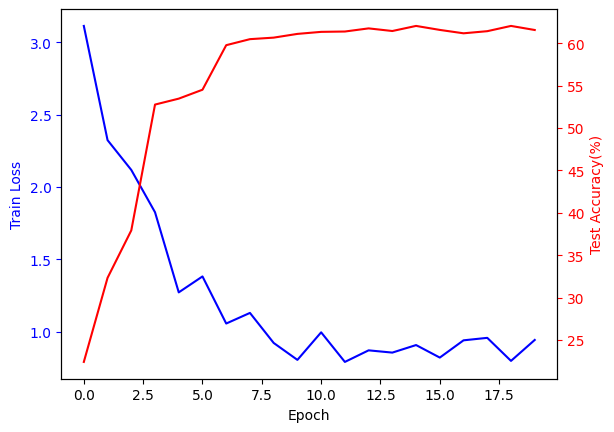

In [10]:
#训练次数
epoch=20

for i in range(epoch):
    train(i)
    scheduler.step()#更新学习率
    test()

fig()

In [11]:
torch.cuda.empty_cache()